In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader

from utils.data import load_hsi_dataset
from utils.plots import reconstruct_map, plot_maps
from modules.datasets.hsi import HyperspectralDataset
from models.conformer.model import ModModel

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
def run_inference_and_plot(
    dataset_name: str,
    num_classes: int,
    checkpoint_path: str,
    root_dir: str = "./data",
    pca_components: int = 30,
    patch_size: int = 15,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hsi_raw, hsi_pca, labels, patches, label_vec = load_hsi_dataset(
        dataset_name, root_dir, pca_components, patch_size, return_all=True
    )

    dataset = HyperspectralDataset(torch.tensor(patches), torch.tensor(label_vec))
    loader = DataLoader(dataset, batch_size=128, shuffle=False)

    model = ModModel(in_channels=pca_components, num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
    all_preds = np.concatenate(all_preds, axis=0)

    h, w = labels.shape
    pred_map = reconstruct_map(all_preds, labels, h, w, patch_size)

    # choose RGB bands for visualization
    rgb_bands = {
        "IndianPines": [43, 21, 11],
        "PaviaUniversity": [55, 41, 12],
        "KSC": [30, 20, 10],
    }[dataset_name]
    rgb = hsi_raw[:, :, rgb_bands]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    plot_maps(rgb, labels, pred_map, dataset_name)

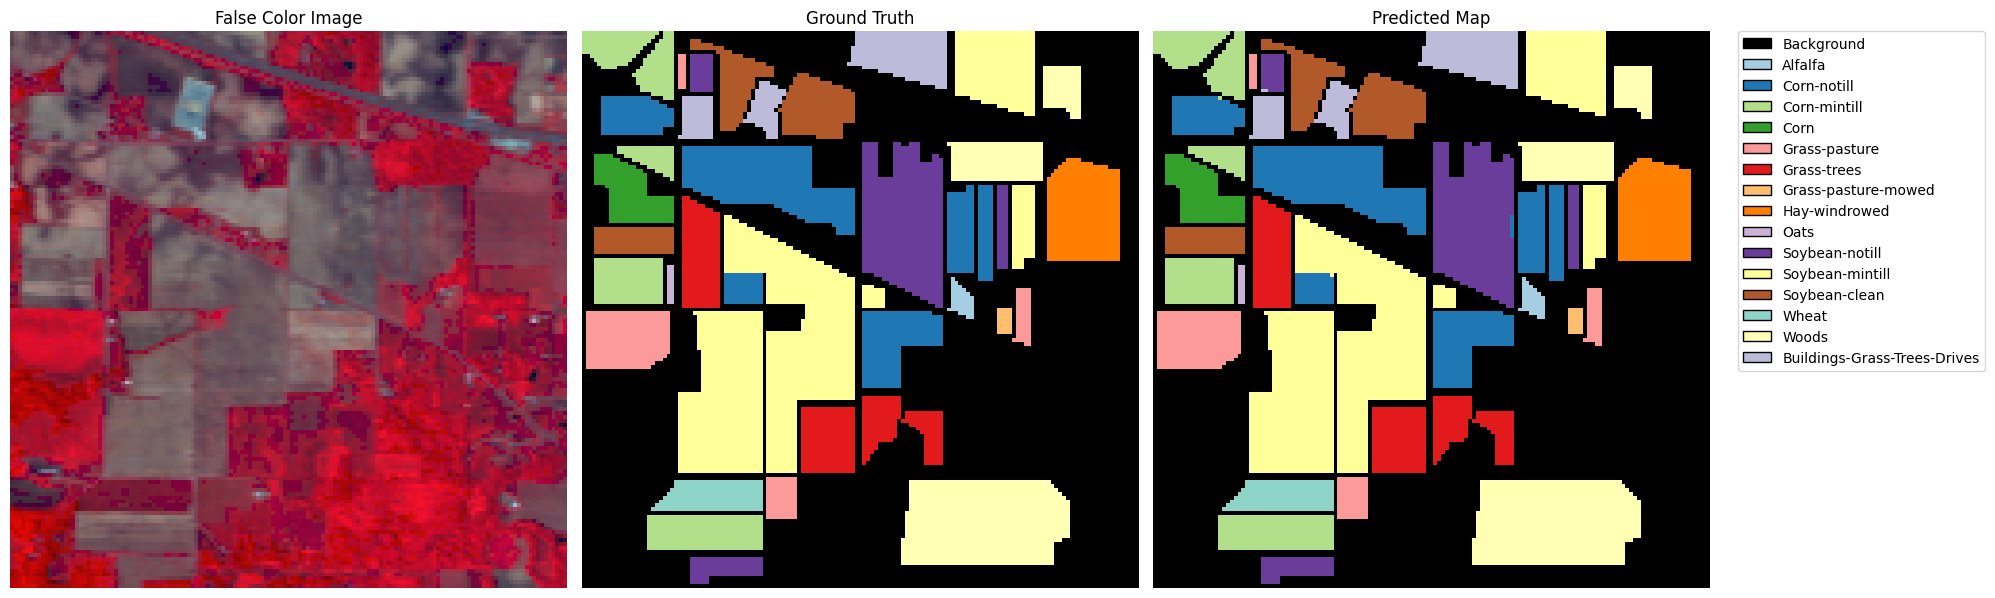

In [7]:
run_inference_and_plot(
    dataset_name="IndianPines",
    root_dir="../data",
    checkpoint_path="../checkpoints/indian_pines_model.pth",
    num_classes=16,
)

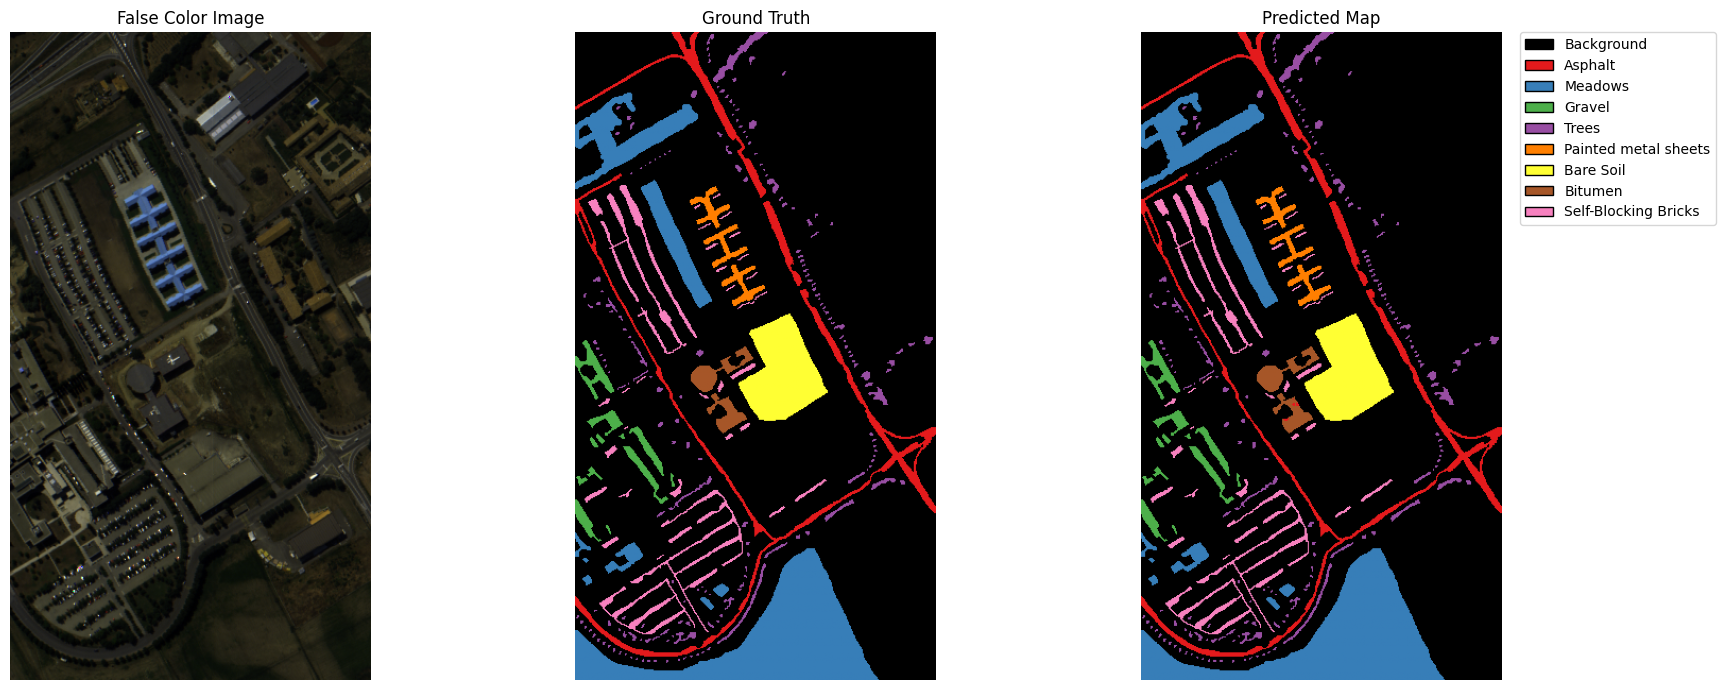

In [8]:
run_inference_and_plot(
    dataset_name="PaviaUniversity",
    root_dir="../data",
    checkpoint_path="../checkpoints/pavia_university_model.pth",
    num_classes=9,
)

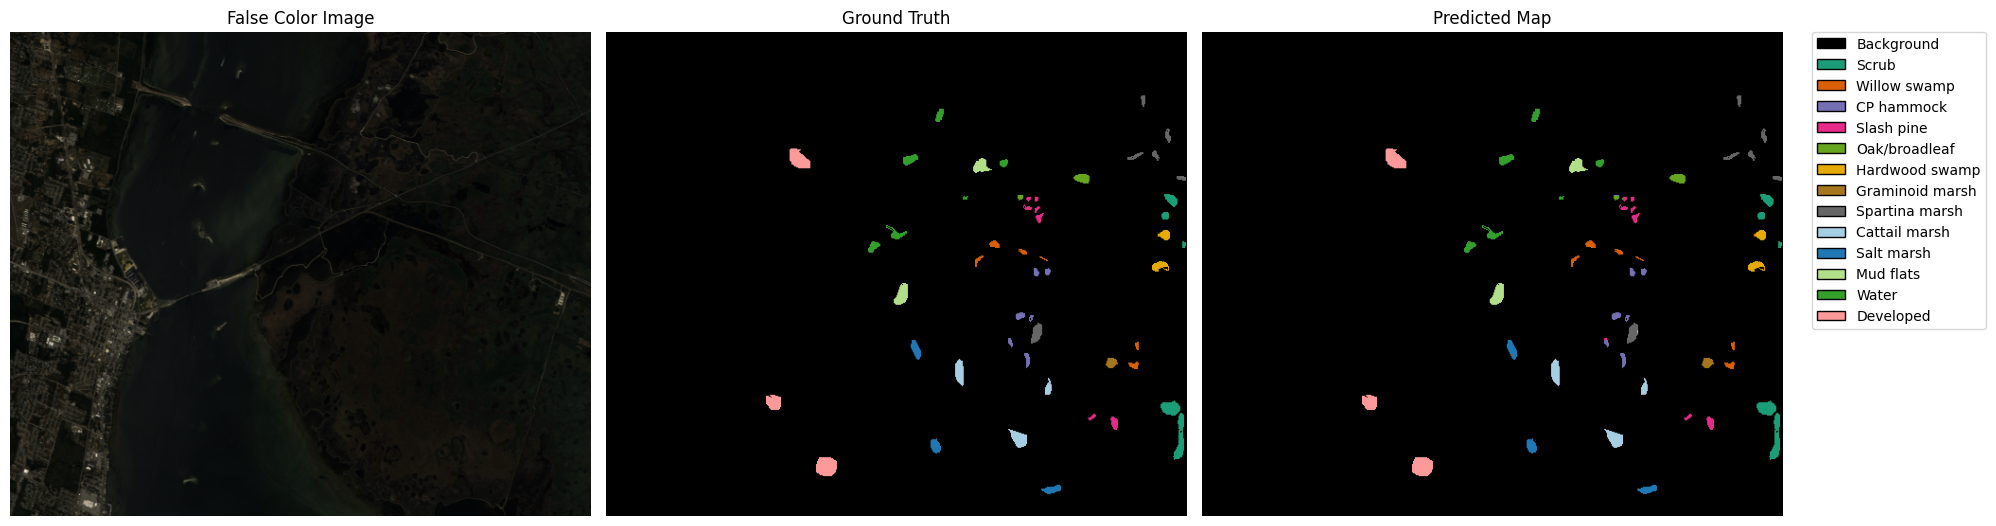

In [9]:
run_inference_and_plot(
    dataset_name="KSC",
    root_dir="../data",
    checkpoint_path="../checkpoints/ksc_model.pth",
    num_classes=13,
)